In [1]:
import os
os.chdir('../..')

In [2]:
from classes.helpers import *
import numpy as np
import json
import pandas as pd
from datetime import datetime

import ast

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib
#matplotlib.rcParams['text.usetex'] = True
#matplotlib.rcParams['text.latex.unicode'] = True

data_folder = '../data/'

# For the Python notebook
%matplotlib inline
%reload_ext autoreload
%autoreload 2

min_nbr_rats = 5

colors = {'ba': (232/255,164/255,29/255), 'rb': (0/255,152/255,205/255)}
labels = {'ba': 'BeerAdvocate', 'rb': 'RateBeer'}

notext = {'ba': 'nan', 'rb': ''}

data_folder = '../data/'
save_folder = '../figures/all/4-herding/'

from matplotlib2tikz import save as tikz_save

def to_inch(x):
    return x*0.393701

In [3]:
df = pd.read_csv(data_folder + 'tmp/time_series_{}.csv'.format(min_nbr_rats), header=[0,1])

# Transform strings into arrays
for i in df.index:
    for key1 in ['ba', 'rb']:
        for key2 in ['dates', 'ratings', 'z_scores']:
            arr = ast.literal_eval(df.loc[i][key1][key2])
            df.set_value(i, (key1, key2), arr)

In [4]:
with open(data_folder + 'tmp/global_averages.json') as file:
    global_avg = json.load(file)

diffs = {'ba': [], 'rb': []}
for i in df.index:
    row = df.loc[i]
    for key in ['rb', 'ba']:
        diffs[key].append(row[key]['z_scores'][0] - global_avg[key]['z_score'])
        
thresholds = {}

for key in ['ba', 'rb']:
    thresholds[key] = {}
    thresholds[key]['low'] = np.percentile(diffs[key], 15)
    thresholds[key]['high'] = np.percentile(diffs[key], 85)

In [5]:
for key in ['ba', 'rb']:
    tmp = []
    nbr_rats = []
    
    for i in df.index:      
        if diffs[key][i] > thresholds[key]['high']:
            tmp.append('H')
        elif diffs[key][i] >= thresholds[key]['low']:
            tmp.append('M')
        else:
            tmp.append('L')
            
        nbr_rats.append(len(df.loc[i][key]['ratings']))

    df.loc[:, (key, 'class')] = tmp
    df.loc[:, (key, 'nbr_ratings')] = nbr_rats

In [6]:
subdf = df[((df['ba']['class'] == 'H') & (df['rb']['class'] == 'L')) | 
           ((df['ba']['class'] == 'L') & (df['rb']['class'] == 'H'))]
subdf.index = range(len(subdf))

In [7]:
diff = []
for i in subdf.index:
    row = subdf.loc[i]
    diff.append(np.abs(row['ba']['avg_z_scores']-row['rb']['avg_z_scores']))
    

In [8]:
idx = np.argsort(diff)[::-1]

In [9]:
pos = 22
row = subdf.loc[idx[pos]]    

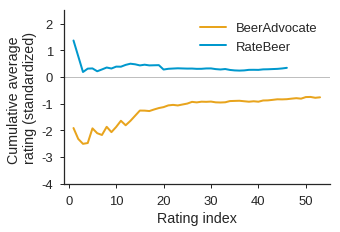

In [47]:
plt.figure(figsize=(5, 3.5), frameon=False)

plt.style.use(['seaborn-white', 'seaborn-paper'])
sns.set(font_scale = 2)
sns.set_context("paper")
sns.set_style("white", {
    "font.family": "sans-serif",
    "font.serif": ['Helvetica']
})

ax = plt.subplot(111)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for key in ['ba', 'rb']:

    rats = row[key]['z_scores']

    rmean = np.cumsum(rats)/np.array(range(1, len(rats)+1))

    ax.plot(list(range(1, len(rmean)+1)), rmean, color=colors[key], label=labels[key], linewidth=2)

plt.ylabel('Cumulative average \nrating (standardized)')
plt.xlabel('Rating index')

leg = plt.legend()
leg.get_frame().set_linewidth(0.0)
plt.tight_layout()

plt.savefig(save_folder + 'timeseries_avg_zscore_example.pdf', bbox_inches='tight')

In [ ]:
row = subdf.loc[idx[pos]]    
print(pos)

plt.figure(figsize=(12,7))
plt.rc('font', family='serif')
plt.rc('font', size=17)

for key in ['ba', 'rb']:

    rats = row[key]['z_scores']

    rmean = np.cumsum(rats)/np.array(range(1, len(rats)+1))

    plt.plot(list(range(1, len(rmean)+1)), rats, color=colors[key], label=labels[key])

plt.ylabel('Standardized rating')
plt.xlabel('Index of the rating')
plt.legend()
plt.grid()
plt.savefig(save_folder + 'timeseries_zscore_example.pdf', bbox_inches='tight')

22
